In [367]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn
from matplotlib import colors
import wordcloud
from scipy.optimize import curve_fit
DATA_DIRECTORY = "./data"
%matplotlib inline

Loading in the data and pivoting to get 
* absolute numbers of babies with each name each year, and
* the proportion of babies born each year with each name.

We'll split by gender as well.

In [14]:
rawdata = pd.concat([pd.read_csv(os.path.join(DATA_DIRECTORY, fname),
                                 header=None, 
                                 names=["state","gender", "year", "name", "num"],
                                 ) 
                     for fname in os.listdir(DATA_DIRECTORY)])
rawdata = rawdata[['name', 'year', 'gender', 'state', 'num']]
rawdata = rawdata[rawdata.year >= 1920]
rawdata = rawdata.sort_values(by=["name", "year"])

In [15]:
pivot_sum_M = rawdata[rawdata.gender=="M"].pivot_table(index="year", columns="name", values="num", aggfunc=sum, fill_value=0)
pivot_prop_M = pivot_sum_M.div(pivot_sum_M.sum(axis=1), axis=0)

pivot_sum_F = rawdata[rawdata.gender=="F"].pivot_table(index="year", columns="name", values="num", aggfunc=sum, fill_value=0)
pivot_prop_F = pivot_sum_F.div(pivot_sum_F.sum(axis=1), axis=0)

pivot_sum = rawdata.pivot_table(index="year", columns="name", values="num", aggfunc=sum, fill_value=0)
pivot_prop = pivot_sum.div(pivot_sum.sum(axis=1), axis=0)

Let’s start by looking at the total babies born each year, and the number of different names in the dataset.

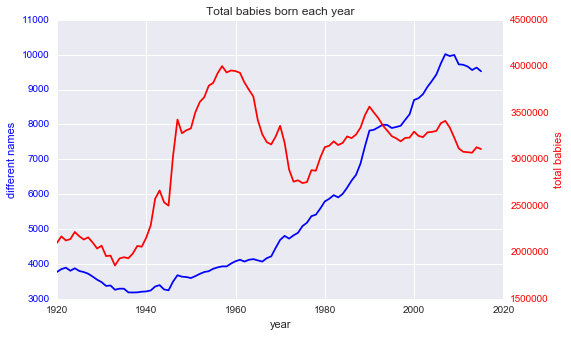

In [521]:
count_names = (pivot_sum > 0).sum(axis=1)
fig, ax1 = plt.subplots()

ax1.plot(count_names.index, count_names.values, 'b-')
ax1.set_xlabel('year')
ax1.set_ylabel('different names', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(count_names.index, pivot_sum.sum(axis=1), 'r-')
ax2.set_ylabel('total babies', color='r')
ax2.tick_params('y', colors='r')
ax2.grid(b=False)
plt.title("Total babies born each year")

## Names and Ethnic Diversity

We can immediately see that there’s a steady increase in the number of different names in the dataset. We’d expect to see more different names as more babies are born, so let’s normalise by the number of babies born each year.

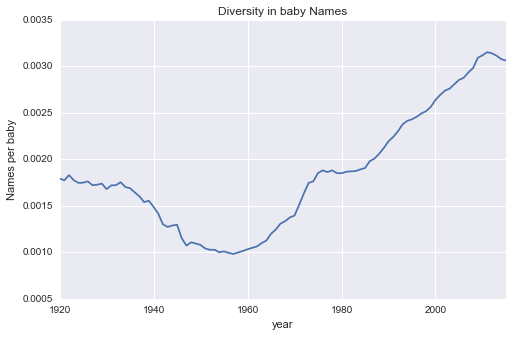

In [523]:
(count_names / pivot_sum.sum(axis=1)).plot()
plt.title("Diversity in baby Names")
plt.ylabel("Names per baby")
plt.show()

We can see that the diversity of names decreased in the baby boom years and increased steadily from about 1960. There a few possible explanations,  but  I wondered in particular if this can be explained by increased diversity: with more different ethnicities in America, should we expect a greater variety of names as well? To test this, I grabbed a dataset of ethnic diversity off of Wikipedia and munged it into something usable.

In [524]:
diversity_1 = pd.read_table("diversity.txt", sep="\t", nrows=7, index_col="Race/Ethnic Group").T
diversity_2 = pd.read_table("diversity.txt", sep="\t", skiprows=8, index_col="Race/Ethnic Group").T
diversity = diversity_1.append(diversity_2).fillna(0)
diversity = diversity.applymap(lambda x: int(x.replace(",", "")) if type(x) == str else x)
diversity.index = diversity.index.astype(int)
diversity = diversity.loc[diversity.index >= 1910]

# Combine "two or more races" with other, for consistency across time.
diversity["Some other race"] += diversity["Two or more races"]
diversity = diversity.drop("Two or more races", axis=1)

# In 1930, there's no data for hispanic or non-hispanic white populations.
# We deal with this by taking the "White" number and splitting it across Hispanic and Non-Hispanic White, 
# in proportion to the average distribution across the rest of the data.
# This isn't perfect: "Hispanic" includes some non-whites, but a small number in relative to the total population
# so it'll serve for our purposes.
hispanicprop = diversity[['Hispanic (of any race)', 'Non-Hispanic White']].sum(axis=0) 
hispanicprop /= hispanicprop.sum()
diversity.loc[1930, "Non-Hispanic White"] = diversity.loc[1930, "White"] * hispanicprop.loc["Non-Hispanic White"]
diversity.loc[1930, 'Hispanic (of any race)'] = diversity.loc[1930, "White"] * hispanicprop.loc['Hispanic (of any race)']

# Drop unneeded columns
diversity = diversity.drop(["Total Population", "White"], axis=1)
proportions = diversity.div(diversity.sum(axis=1), axis=0)
proportions

,"American Indian, Eskimo, and Aleut",Asian and Pacific Islander,Black,Hispanic (of any race),Non-Hispanic White,Some other race
1910,0.002885,0.001595,0.106729,0.008666,0.880125,0.000000
1920,0.002311,0.001722,0.098914,0.012159,0.884895,0.000000
1930,0.002707,0.002157,0.096853,0.078835,0.819448,0.000000
1940,0.002535,0.001935,0.097660,0.015347,0.882522,0.000000
1950,0.002277,0.002129,0.099755,0.021430,0.874087,0.000322
1960,0.003073,0.005461,0.105122,0.032390,0.853467,0.000488
1970,0.003905,0.007496,0.110685,0.043809,0.832976,0.001130
1980,0.006095,0.015021,0.113693,0.062688,0.773502,0.029001
1990,0.007550,0.028029,0.115550,0.086141,0.724947,0.037783
2000,0.008258,0.035494,0.115597,0.117757,0.648899,0.073995


o get a measure of diversity we’ll use Shannon Entropy, a common measure of the uncertainty (or variation, or entropy) in data. I originally encountered this measure in a Cryptography class but it’s used in Biology, Physics, Game Theory… it’s just so applicable! If your variable (in this case, race) can take values x with probability p(x),  then Shannon Entropy is:

In [525]:
#
# H = ⎲  -p(x) log( p(x) ). 
#     ⎳x

If your variable can take only one value, with p=1, then H=0 because there is no uncertainty. If you have k equally probably outcomes then your entropy is log(k) . The more evenly distributed your variable is and the more different options there are, the higher the entropy, making it a good measure of diversity. 

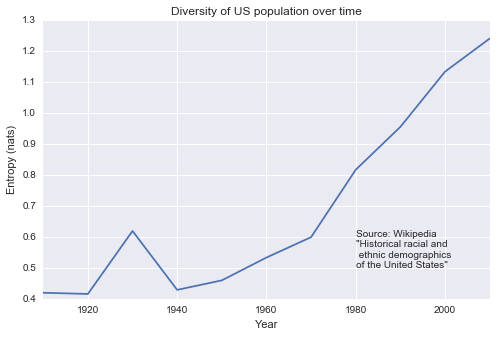

In [528]:
def shannonentropy(data):
    proportions = data.div(data.sum(axis=1), axis=0)
    return -(np.log(proportions) * proportions).sum(axis=1)
shannonentropy(diversity).plot()
plt.title("Diversity of US population over time")
plt.ylabel("Entropy (nats)")
plt.xlabel("Year")
plt.text(1980, 0.5, 'Source: Wikipedia \n"Historical racial and\n ethnic demographics\nof the United States"')
plt.show()



We originally used the number of different names per baby as a rough measure of naming diversity. This is pretty basic though as it doesn’t take into account the relative frequencies of each name within a year. We can do better by using exactly the same tool again, entropy! Let’s get the naming entropy of each year instead. The higher the entropy the more diversity there is in naming.

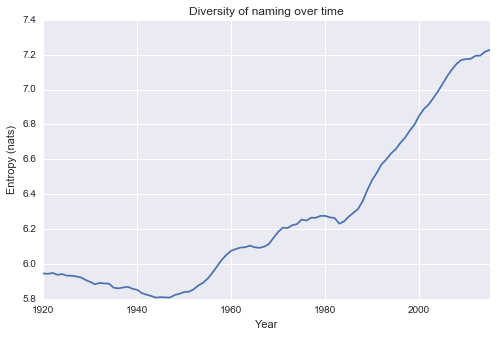

In [526]:
shannonentropy(pivot_prop).plot()
plt.title("Diversity of naming over time")
plt.xlabel("Year")
plt.ylabel("Entropy (nats)")

Applying Shannon Entropy to the US census ethnography data gives the graph below. We can see that trend in ethnic diversity does mirror the baby name diversity pretty closely. Unfortunately we must remember that correlation doesn’t imply causation though, and in this sample of one country with such seismic social changes occurring throughout the century this might just be a coincidence. A more thorough analysis would look at names given to babies of each different nationality.

# The Lifecycle of a Name

Let’s look at the distributions over time of the most popular boys’ and girls’ names. These are the twenty names with the highest total share of naming over the century:

In [529]:
NNAMES = 20
popular_names_M = pivot_prop_M.loc[:,pivot_prop_M.sum(axis=0).rank(ascending=False) <= NNAMES]
popular_names_F = pivot_prop_F.loc[:,pivot_prop_F.sum(axis=0).rank(ascending=False) <= NNAMES]

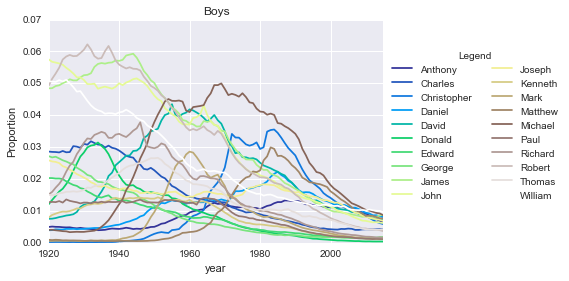

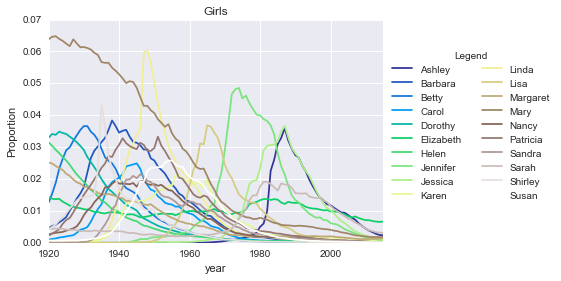

In [268]:
popular_names_M.plot(legend=None, colormap='terrain')
plt.title("Boys")
plt.ylabel("Proportion")
plt.legend(loc="upper left", bbox_to_anchor=(1, 0.9),
           ncol=2, shadow=True, title="Legend", fancybox=True)
popular_names_F.plot(legend=None, colormap='terrain')
plt.title("Girls")
plt.ylabel("Proportion")
plt.legend(loc="upper left", bbox_to_anchor=(1, 0.9),
           ncol=2, shadow=True, title="Legend", fancybox=True)

It’s kinda interesting that they all collapse into the new millenium. That might be because old names are really be going out of fashion in the digital age… but it’s also true that there’s a trend to having a wider diversity of names, as we proved with our entropy calculation just above. 

I noticed that the most popular girls’ names seem to have shorter ‘life cycles’ than the most popular boys’ names. On the boys’ side most names are popular for most of the century; on the girls’ side popular names bubble up and collapse with a lifecycle of just a decade or two. Am I just imagining this? Maths can tell us!

In [269]:
def names_stdev(pivot):
    mean_year = (pivot.rmul(pivot.index.values, axis='rows') / pivot.sum()).sum()
    squared_deviations = pivot * pd.DataFrame([{name: (mean_year[name]-year)**2 for name in pivot.columns}
                                                   for year in pivot.index],
                                                  index=pivot.index)
    stdev = np.sqrt(squared_deviations.sum() / pivot.sum()).mean()
    return stdev

print("Boys  : {0:.2f}".format(names_stdev(popular_names_M)))
print("Girls : {0:.2f}".format(names_stdev(popular_names_F)))

Boys  : 21.21
Girls : 14.62


I’m not making it up! The most popular boys’ names have a considerably wider distribution than the girls’ names, with a standard deviation 1.5x as long. 

So it appears that girls’ names do rise and fall faster than boys’ names, at least for the more popular names. In fact, by calculating the entropy of each gender individually we can see that girls’ names are consistently more varied than boys’ names — though not by all that much.

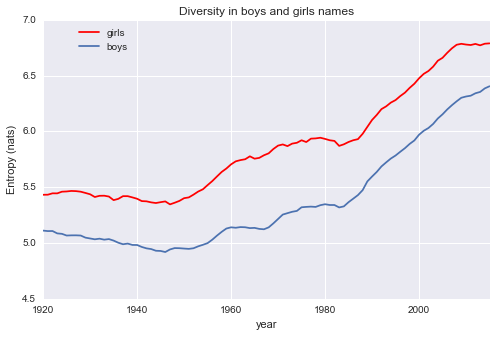

In [530]:
F = shannonentropy(pivot_prop_F)
F.name = "girls"
F.plot(color='r')
M = shannonentropy(pivot_prop_M)
M.name = "boys"
M.plot()
plt.legend(bbox_to_anchor=(0.21, 1))
plt.title("Diversity in boys and girls names")
plt.ylabel("Entropy (nats)")

# Distinctive names: what name most calls up a certain year?


It’s easy to understand how to find the most common name in each year. You just find a year, count all the names in the year, and pick the most common. Obviously. What we’re doing there is picking name for a given year so as to maximise P(name | year). (P is probability.)

What if we instead pick name to maximise P(year | name)? This is a more subtle concept which is why I think it’s fun. What we’re doing there is finding the name which best ‘characterises’ a given year , the name which would most make us say “oh, you must have been born in year !”. 

Let’s calculate. I got rid of all names which never account for more than 1% of names in a year because it’s hard to think of them as representative of an era, then calculated P(year | name) and visualised the maxima.

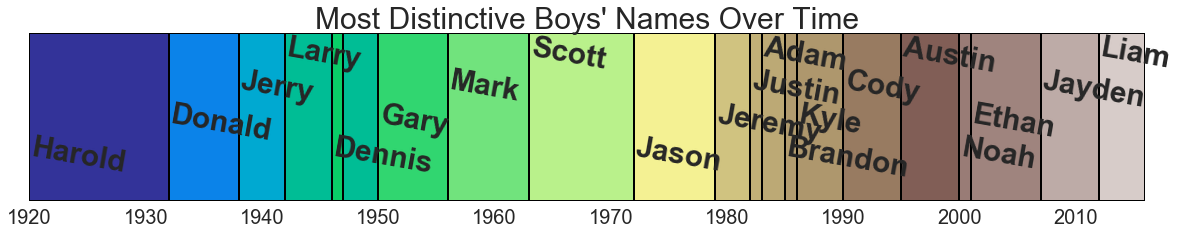

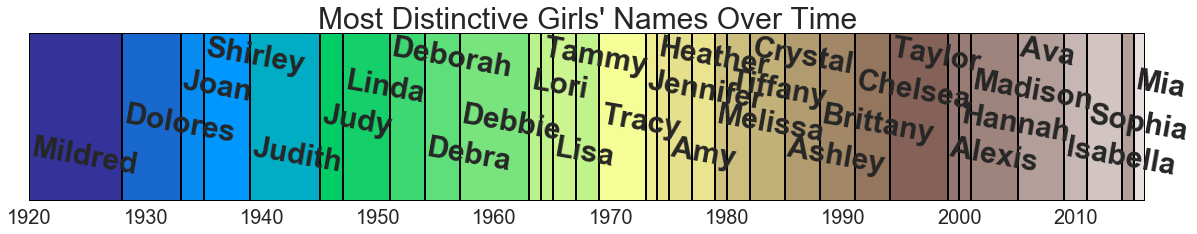

In [515]:
def distinctive_names(pivottable, genderword, CUTOFF=0.01):
    distinctive_names = pivottable.T[pivottable.max() >= CUTOFF].T
    distinctive_names = (distinctive_names / distinctive_names.sum()).idxmax(axis=1)

    fig, ax = plt.subplots(1,1)
    plt.axis([1920,2016,0,10])
    ax = plt.gca()
    ax.set_autoscale_on(False)

    distinctive_names.name = "dname"
    
    groups = sorted(list(distinctive_names.groupby(by=distinctive_names)), key=lambda x: x[1].index.min())

    for n, i in enumerate(groups):
        xmin = i[1].index.min()
        xmax = i[1].index.max()
        name = i[0]
        ax.add_patch(
        patches.Rectangle(
            (xmin, 0),
            xmax-xmin+1, 10,
            facecolor=plt.get_cmap("terrain")((i[1].index.min()-1920)/100),
            linewidth=2, alpha=1, ls='solid'),
            )  
        plt.text(i[1].index.min(),4+((2*n)%8),i[0],size=30, rotation=350, va='top', weight='bold'
                )
    ax.get_yaxis().set_ticklabels([])
    plt.tick_params(axis='x', which='major', labelsize=20)
    plt.xticks(np.arange(1920,2011,10))
    plt.title("Most Distinctive {}' Names Over Time".format(genderword), size=30)
    plt.show()
    

plt.rcParams['figure.figsize'] = (20,3)
distinctive_names(pivot_prop_M,"Boys")
distinctive_names(pivot_prop_F,"Girls",CUTOFF=0.01)
plt.rcParams['figure.figsize'] = (8,5)

I think it’s fairly effective! The names given do feel distinctive for their eras, at least to my ears. I also think I need to learn some proper dataviz tools. Some day…

## Agendered Names

Something kinda surprising in this dataset is the number of babies given names traditionally reserved for the opposite sex. Apparently there have been 10 babies born as girls and named Frederick; 21 born as boys and named Janice; 17201 born as girls and named Michael. Ok most of these are probably (?) mistakes, either on the social security application or in the data aggregation. But it got me thinking about names which can apply to both sexes.

Let’s find names which can easily apply to both sexes. Another way of saying that is, we want names which have a lot of uncertainty about indicating sex. Hey, we already have a function for measuring uncertainty —  Shannon Entropy. As the old saying goes: if life gives you lemons, sum your data over the years axis, filter to remove less interesting low-frequency data, apply your lemon and sort by the most lemony data points. Or something like that.

In [181]:
CUTOFF = 10000
MFNames = pd.concat(pivot_sum_M.sum().T.align(pivot_sum_F.sum().T, join="inner"), axis=1).rename(columns={0:"M", 1:"F"})
MFNames = MFNames.loc[MFNames.min(axis=1) > CUTOFF]
MFNames['entropy'] = shannonentropy(MFNames)
MFNames.sort_values(by="entropy", ascending=False)

,M,F,entropy
name,,,
Robbie,16880,16967,0.693144
Kerry,46277,45624,0.693122
Kris,10749,11022,0.693069
Riley,83789,86436,0.693026
Justice,14117,13474,0.692876
Emerson,13487,14323,0.692695
Jessie,88984,101533,0.690976
Jackie,74585,86377,0.690461
Amari,13168,11284,0.690176


In [169]:
def plot_name_MF(name):
    try:
        fig, ax1 = plt.subplots()
        plt.title(name)
        ax1.plot(pivot_sum_M[[name]].index, pivot_sum_M[[name]].values, color='b')
        ax1.plot(pivot_sum_F[[name]].index, pivot_sum_F[[name]].values, color='r')
        ax1.set_xlabel('year')
        # Make the y-axis label, ticks and tick labels match the line color.
        ax1.set_ylabel('Male', color='b')
        ax1.tick_params(right='off')
        ax1.grid(b=False)
        plt.legend()
        ax2 = ax1.twinx()
        ax2.set_ylabel('Female', color='r')
        ax2.axes.get_yaxis().set_ticklabels([])
        #ax2.set_visible(False)
        #cur_axes.axes.get_xaxis()
        
        plt.title(name)
    except KeyError:
        print("{} not found :(".format(name))

//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


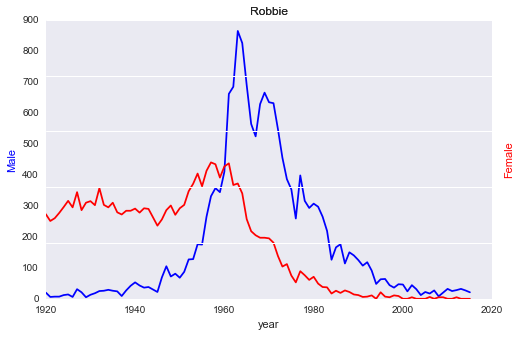

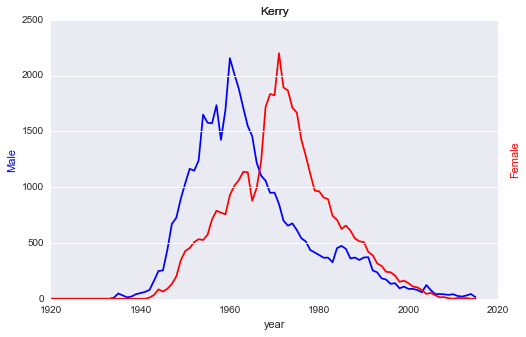

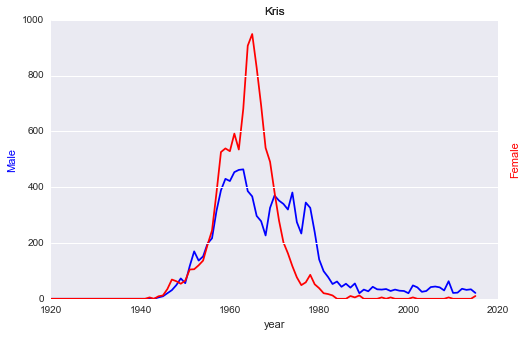

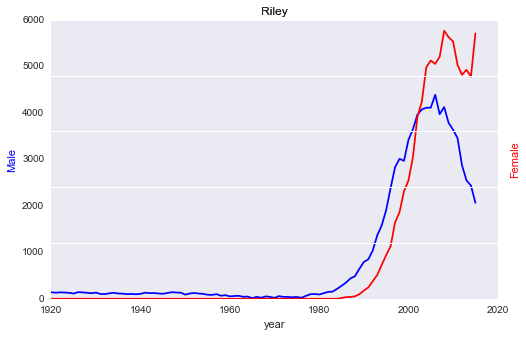

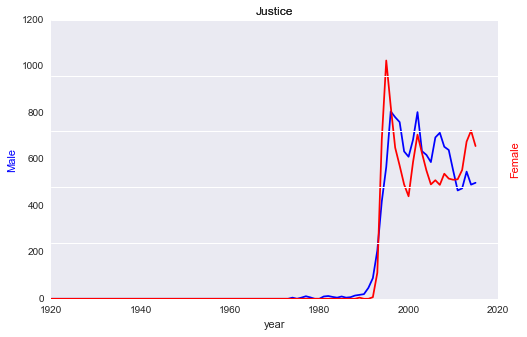

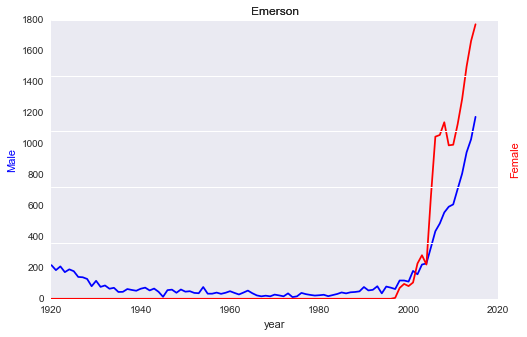

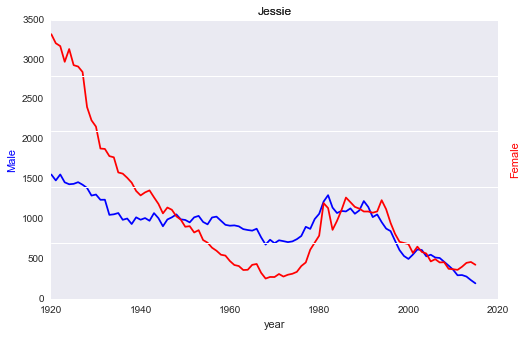

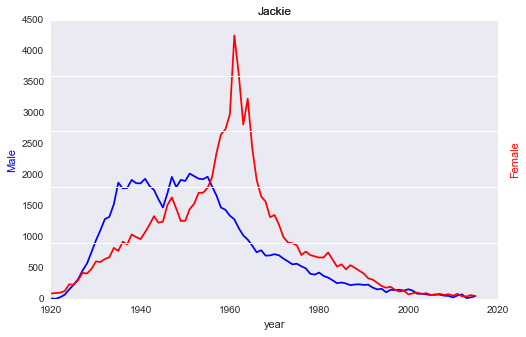

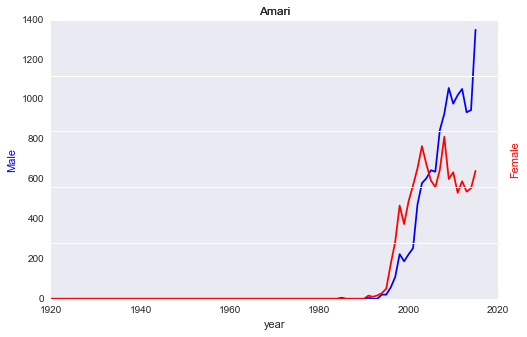

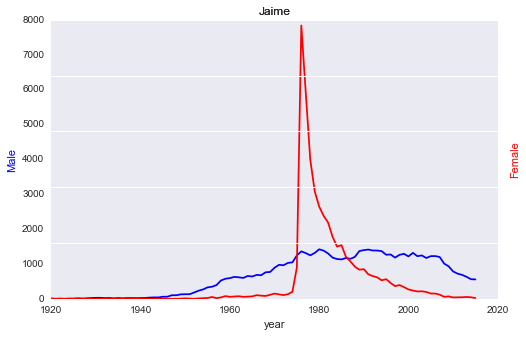

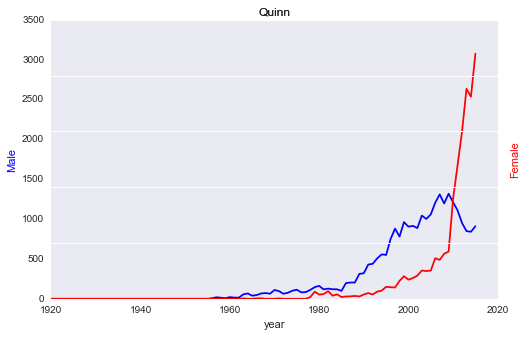

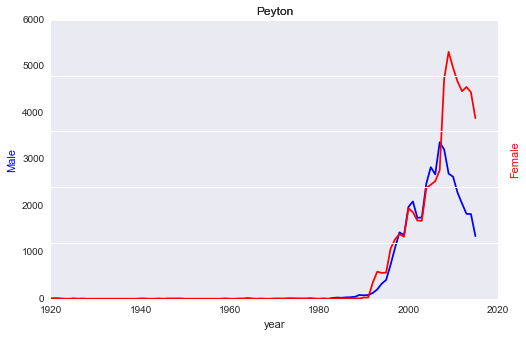

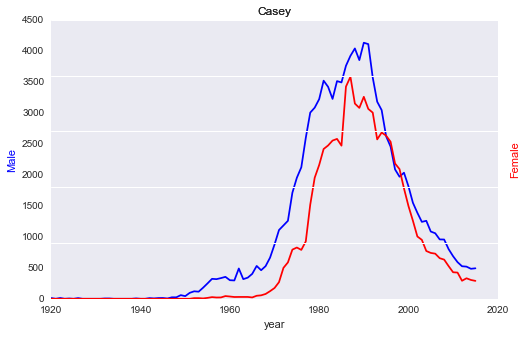

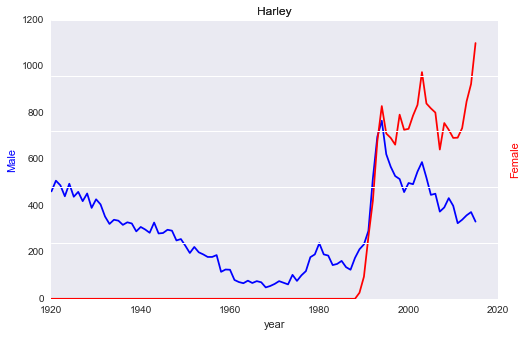

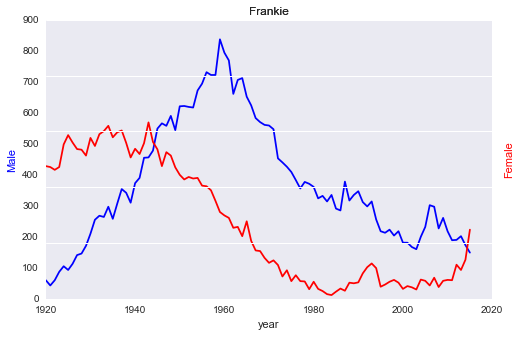

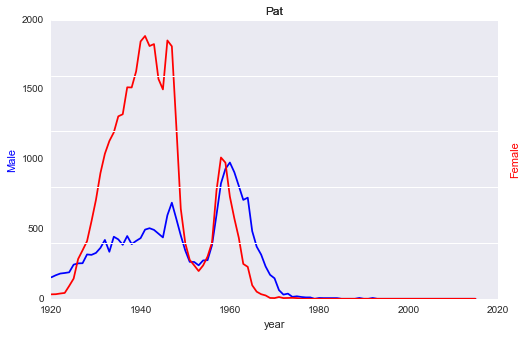

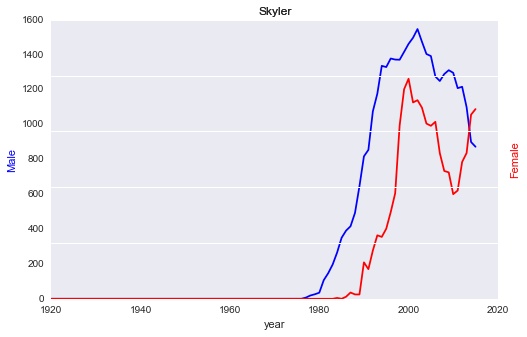

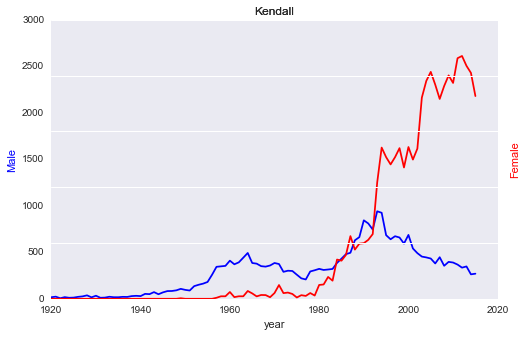

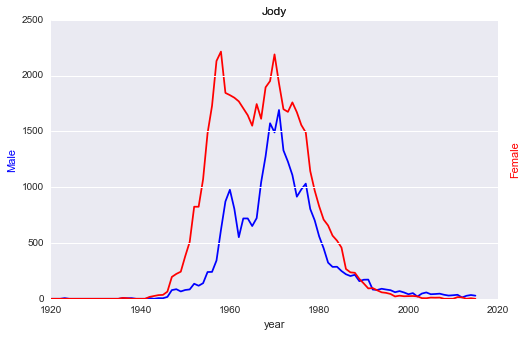

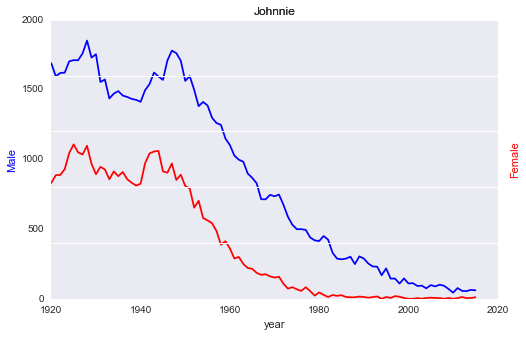

In [532]:
[plot_name_MF(name) for name in MFNames.sort_values(by="entropy", ascending=False).head(20).index]
None

As best I can figure out, often the reason a name can suddenly and abruptly switch gender connotations is because of a famous figure. Jackie peaked in popularity as a girls’ name when Jackie Kennedy entered the White House. Ashton jumped in popularity when Ashton Kutcher started appearing on TV screens. Jamie and Jaime both exploded as a girls’ name at exactly the time that ‘The Bionic Woman’ first aired in the USA, with the lead character Jaime Sommers as one of TV’s first kickass female superheroes.

Even when the bump fades after a few years, it seems often to be enough to cement the change in gendering of a name: female Ashtons dropped right off after 2000, and since Harley Quinn appeared in 1992 there have been consistently more girls named Harley than boys. This trend isn’t entirely consistent though, as with the Jaime graph above.

# Presidents - do presidents get a naming boost to babies born in the first year of their first term?

We’ve seen that famous people can have an effect on baby names. What about the most famous person in the US of all, the POTUS? Let’s calculate the effect which a new president has on babies born that year. We’ll take the number of babies born with the president’s name in his first year of office and calculate how many standard deviations away from the mean it is, as a measure of what a ‘bump’ he has compared to the background level of popularity.

In [534]:
def variance_over_year(yearsnamesdf):
    # Takes in a df with  which has columns "year" and "name" to evaluate.
    # Calculates what the variance of each name is in that year, compared to the average over the time period.
    yearsnamesdf = yearsnamesdf.dropna()
    years_v_names = yearsnamesdf.join(pivot_prop.T, on="name")
    years_v_names = years_v_names.set_index(years_v_names.year)
    sdev = np.sqrt(years_v_names.iloc[:,2:].var(axis=1))
    mean = np.mean(years_v_names.iloc[:,2:], axis=1)
    deviation = (years_v_names.lookup(years_v_names.year.astype(int),
                                        years_v_names.year.astype(int)) 
                 - mean) / sdev
    deviation.name = "stdevs"
    return yearsnamesdf.join(deviation, on="year")

In [536]:
presidents = pd.DataFrame([[1923, "Calvin"],
                          [1933, "Franklin"],
                          [1945, "Harold"],
                          [1953, "Dwight"],
                          [1964, "Lyndon"],
                          [1970, "Richard"],
                          [1975, "Gerald"],
                          [1977, "James"],
                          [1981, "Ronald"],
                          [1989, "George"],
                          [1993, "Bill"],
                          [2001, "George"],
                          [2009, "Barack"]], columns=['year','name'])
presidents_var = variance_over_year(presidents).dropna()
presidents_var.year = presidents_var.year.astype(int)

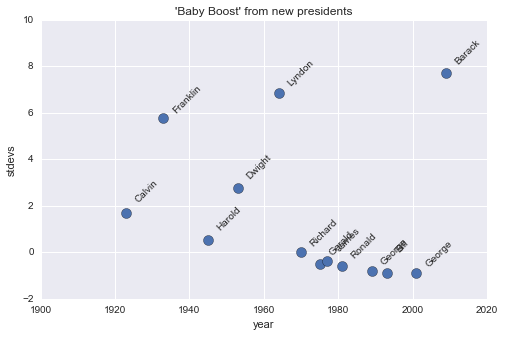

In [538]:
ax = presidents_var.plot.scatter(x='year', y='stdevs', s=100)
plt.title("'Baby Boost' from new presidents")
for i in range(len(presidents_var)):
    row = presidents_var.loc[i]
    ax.annotate(row["name"], [row.year+2, row.stdevs+1.2], rotation=45)

In [533]:
def plot_name(name):
    try:
        fig, ax1 = plt.subplots()
        ax1.plot(pivot_sum[[name]].index, pivot_sum[[name]].values, alpha=1.0, color='y')
        ax1.set_xlabel('year')
        # Make the y-axis label, ticks and tick labels match the line color.
        ax1.set_ylabel('Count', color='b')
        ax1.tick_params('y')
        ax1.grid(b=False)

        ax2 = ax1.twinx()
        ax2.plot(pivot_prop[[name]].index, pivot_prop[[name]].values)
        ax2.set_ylabel('Proportion', color='y')
        ax2.tick_params('y', color='y')
        ax2.grid(b=False)
        plt.title(name, size=16)
    except KeyError:
        print("{} not found :(".format(name))

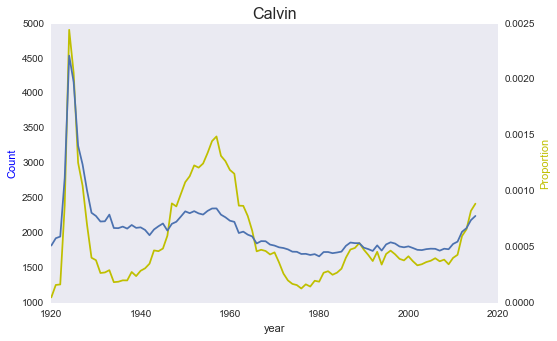

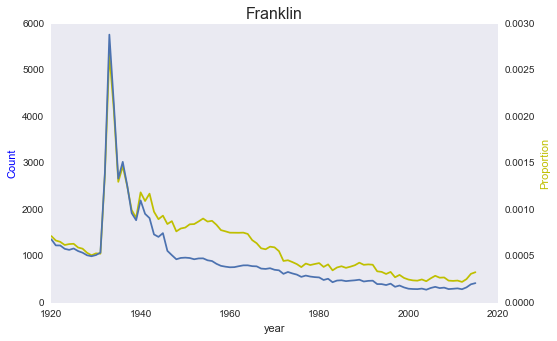

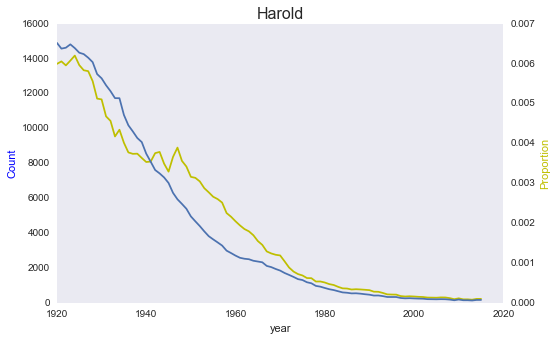

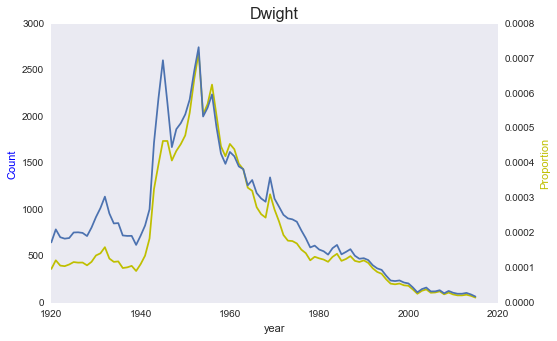

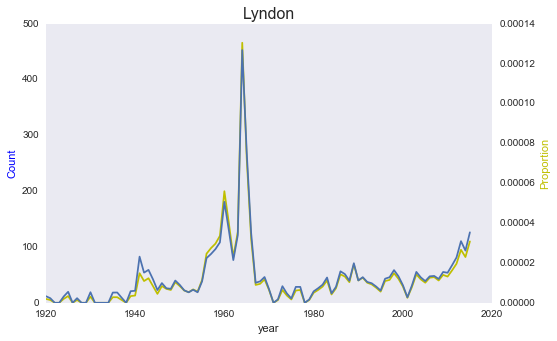

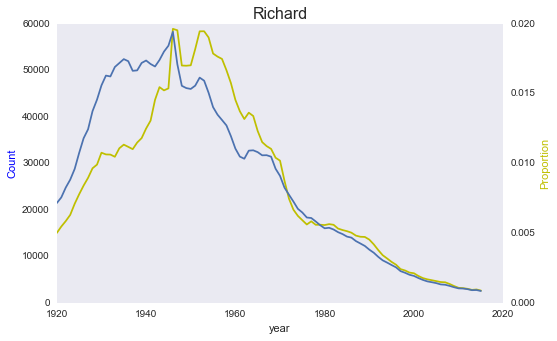

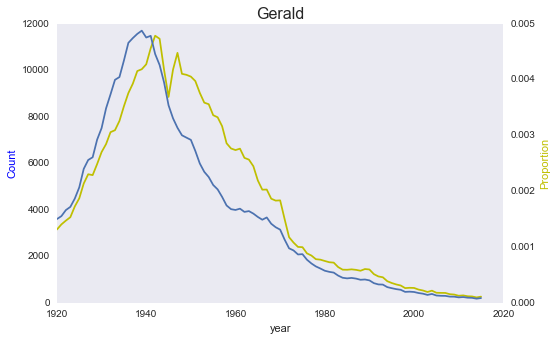

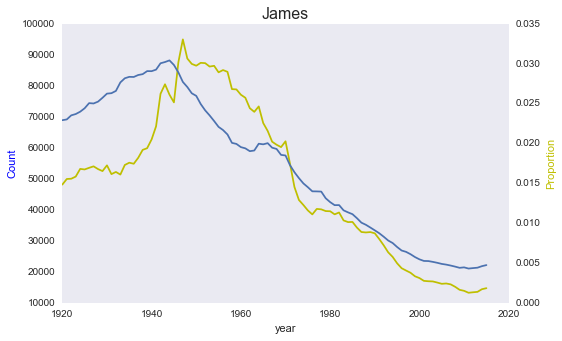

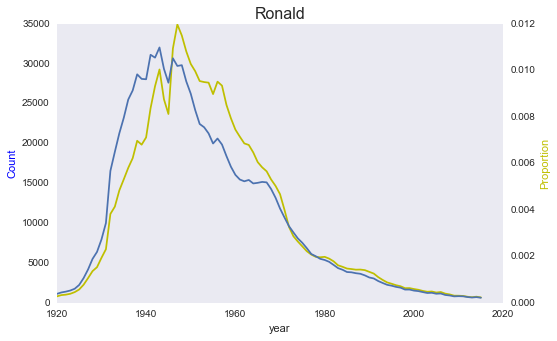

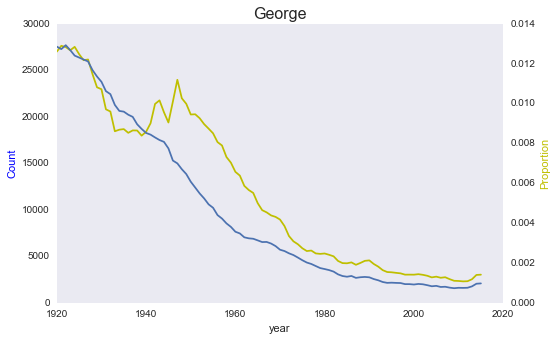

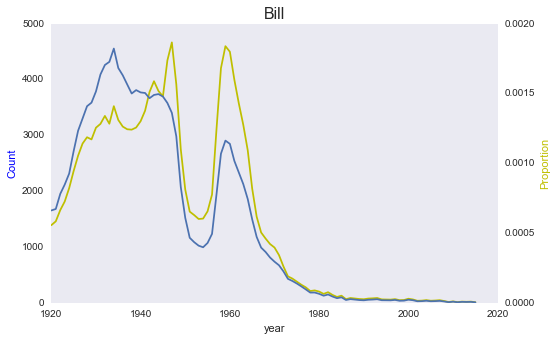

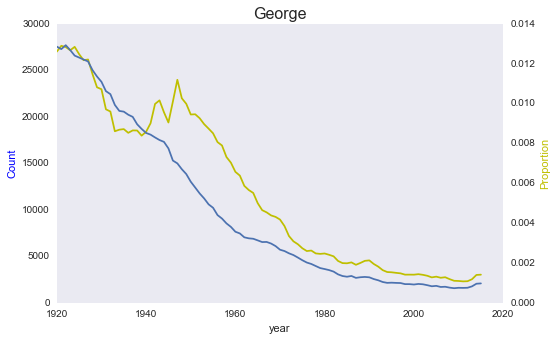

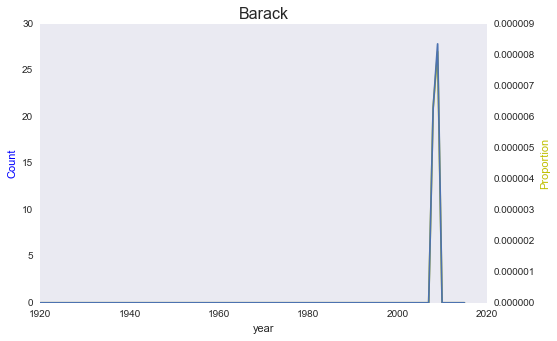

In [539]:
[plot_name(name) for name in presidents.name]
None

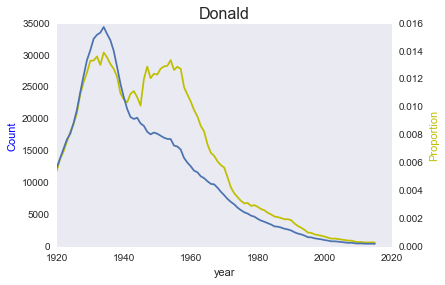

In [257]:
plot_name("Donald")

# BONUS: The Movie Effect.

Does being a lead actor in the year's top movie make more babies be born with your name? Spoiler: maybe, but not really, which is why I didn't include it in the main post. My intuition is that there is a movie start effect in the data, but it's a bit more complex.

In [30]:
movies = pd.read_csv("movie_metadata.csv")
best_movies_per_year = movies.sort_values(
                            ["title_year", "imdb_score"], ascending=False).drop_duplicates(
                                subset=["title_year"], keep="first")

In [31]:
actornames = pd.DataFrame([best_movies_per_year.title_year, best_movies_per_year.actor_1_name.apply(lambda x: re.match(r"^\w+", x).group(0) if re.match(r"^\w+", x) is not None else "")]).T
actornames = actornames.dropna()
actornames = actornames.rename(columns={"title_year": "year", "actor_1_name": "name"})
actornames = actornames.set_index(actornames.year.astype(int))
actornames

,year,name
year,,
2016,2016,Matthew
2015,2015,David
2014,2014,Elina
2013,2013,Michael
2012,2012,Tom
2011,2011,Collin
2010,2010,Leonardo
2009,2009,John
2008,2008,Christian


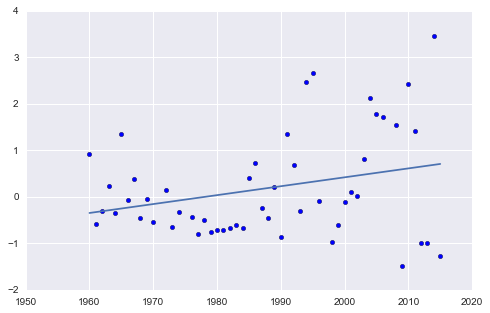

In [543]:
timerange = np.arange(1960, 2016)
var_by_year = variance_over_year(actornames.loc[timerange]).dropna()
fit = curve_fit(lambda x, a, b: a + b*x , var_by_year.year.astype(int), var_by_year.stdevs, [0,0])[0]
plt.scatter( var_by_year.year, var_by_year.stdevs)
vals = (lambda x: fit[0] + fit[1] * x)(timerange)
plt.plot(timerange, vals)